# Búsqueda de hiperparámetros en regresión lineal

En este tutorial trabajaremos con los modelos de regresión lineal. En concreto construiremos modelos lineales aproximados por mínimos cuadrados, así como sus versiones en las que se incorporan las regularizaciones Ridge, Lasso y Elastic Net.

Como último veremos una regresión polinómica

In [24]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.compose import make_column_transformer
from sklearn.compose import TransformedTargetRegressor



# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [25]:
def rmse(y_test, y_test_pred):
  """ Este es mi cálculo del error cuadrático medio """
  return np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

In [26]:
def pintaResultados (reg, n):
  plt.subplots(figsize=(30, 5))
  x = np.arange(y_test[:n].size)
  pred = reg.predict(X=X_test)
  plt.plot(x, y_test[:n], 'b.', label='Estimado')
  plt.plot(x, pred[:n], 'g^', label='Deseado')
  plt.legend(loc='upper right')
  plt.show()

Cargamos los datos

In [27]:
from sklearn.datasets import fetch_openml

survey = fetch_openml(data_id=534, as_frame=True)

In [28]:
print(survey.DESCR)

**Author**:   
**Source**: Unknown - Date unknown  
**Please cite**:   

Determinants of Wages from the 1985 Current Population Survey

Summary:
The Current Population Survey (CPS) is used to supplement census information between census years. These data consist of a random sample of 534 persons from the CPS, with information on wages and other characteristics of the workers, including sex, number of years of education, years of work experience, occupational status, region of residence and union membership. We wish to determine (i) whether wages are related to these characteristics and (ii) whether there is a gender gap in wages.
Based on residual plots, wages were log-transformed to stabilize the variance. Age and work experience were almost perfectly correlated (r=.98). Multiple regression of log wages against sex, age, years of education, work experience, union membership, southern residence, and occupational status showed that these covariates were related to wages (pooled F test, 

In [29]:
X = survey.data[survey.feature_names]
X.describe(include="all")

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
count,534.000000,534,534,534.000000,534,534.000000,534,534,534,534
unique,NaN,2,2,NaN,2,NaN,3,6,3,2
top,NaN,no,male,NaN,not_member,NaN,White,Other,Other,Married
freq,NaN,378,289,NaN,438,NaN,440,156,411,350
mean,13.018727,NaN,NaN,17.822097,NaN,36.833333,NaN,NaN,NaN,NaN
std,2.615373,NaN,NaN,12.379710,NaN,11.726573,NaN,NaN,NaN,NaN
min,2.000000,NaN,NaN,0.000000,NaN,18.000000,NaN,NaN,NaN,NaN
25%,12.000000,NaN,NaN,8.000000,NaN,28.000000,NaN,NaN,NaN,NaN
50%,12.000000,NaN,NaN,15.000000,NaN,35.000000,NaN,NaN,NaN,NaN
75%,15.000000,NaN,NaN,26.000000,NaN,44.000000,NaN,NaN,NaN,NaN


In [30]:
X.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,35,White,Other,Other,Married


In [31]:
y = survey.target.values.ravel()
survey.target.head()

0    5.10
1    4.95
2    6.67
3    4.00
4    7.50
Name: WAGE, dtype: float64

In [32]:
# Holdout para la evaluación del modelo. 33% de los datos disponibles para test
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=42)

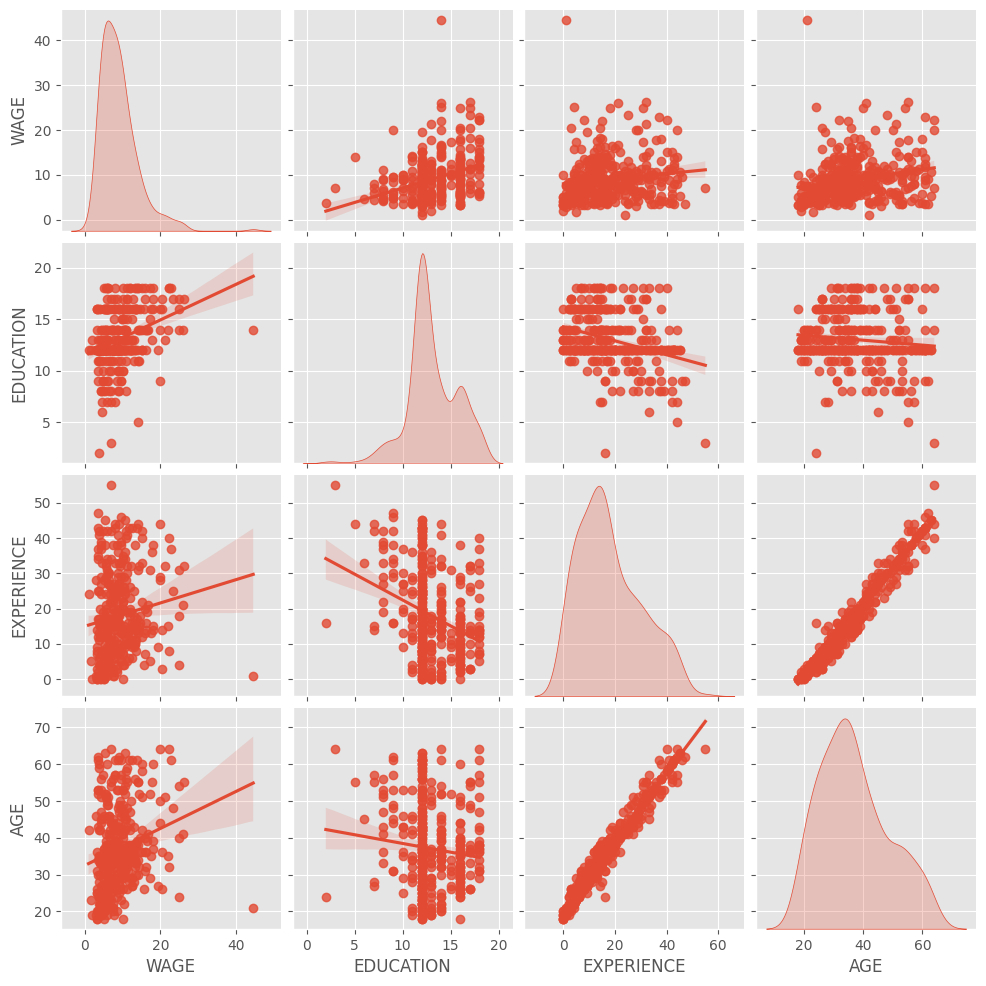

In [33]:
# Analizamos las variables numéricas
# ==============================================================================

train_dataset = X_train.copy()
train_dataset.insert(0, "WAGE", y_train)
_ = sns.pairplot(train_dataset, kind="reg", diag_kind="kde")


In [34]:
survey.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   EDUCATION   534 non-null    int64   
 1   SOUTH       534 non-null    category
 2   SEX         534 non-null    category
 3   EXPERIENCE  534 non-null    int64   
 4   UNION       534 non-null    category
 5   AGE         534 non-null    int64   
 6   RACE        534 non-null    category
 7   OCCUPATION  534 non-null    category
 8   SECTOR      534 non-null    category
 9   MARR        534 non-null    category
dtypes: category(7), int64(3)
memory usage: 17.2 KB


In [35]:
# Definimos el preproceso de las columnas
# ==============================================================================

categorical_columns = X_train.select_dtypes(include="category").columns
numerical_columns = X_train.select_dtypes(exclude="category").columns

# Otra forma
# categorical_columns = ["RACE", "OCCUPATION", "SECTOR", "MARR", "UNION", "SEX", "SOUTH"]
# numerical_columns = ["EDUCATION", "EXPERIENCE", "AGE"]

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary"), categorical_columns),
    (StandardScaler(), numerical_columns),
)

# Otra forma
# preprocesor = ColumnTransformer(
#    [('categoricos', OneHotEncoder(drop="if_binary"),categorical_columns),
#     ('numericos', StandardScaler(), numerical_columns)]
#    )

## Regresión lineal por mínimos cuadrados

In [36]:
# Creación y entrenamiento del modelo lineal
# ==============================================================================

pipe_regr = Pipeline([
        ('preproceso', preprocessor),
        ('regresor', LinearRegression())
])

np.random.seed(42)
pipe_regr.fit(X_train, y_train)

Pipeline(steps=[('preproceso',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  Index(['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR'], dtype='object')),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  Index(['EDUCATION', 'EXPERIENCE', 'AGE'], dtype='object'))])),
                ('regresor', LinearRegression())])

RMSE de regresión lineal: 4.305 $/hora


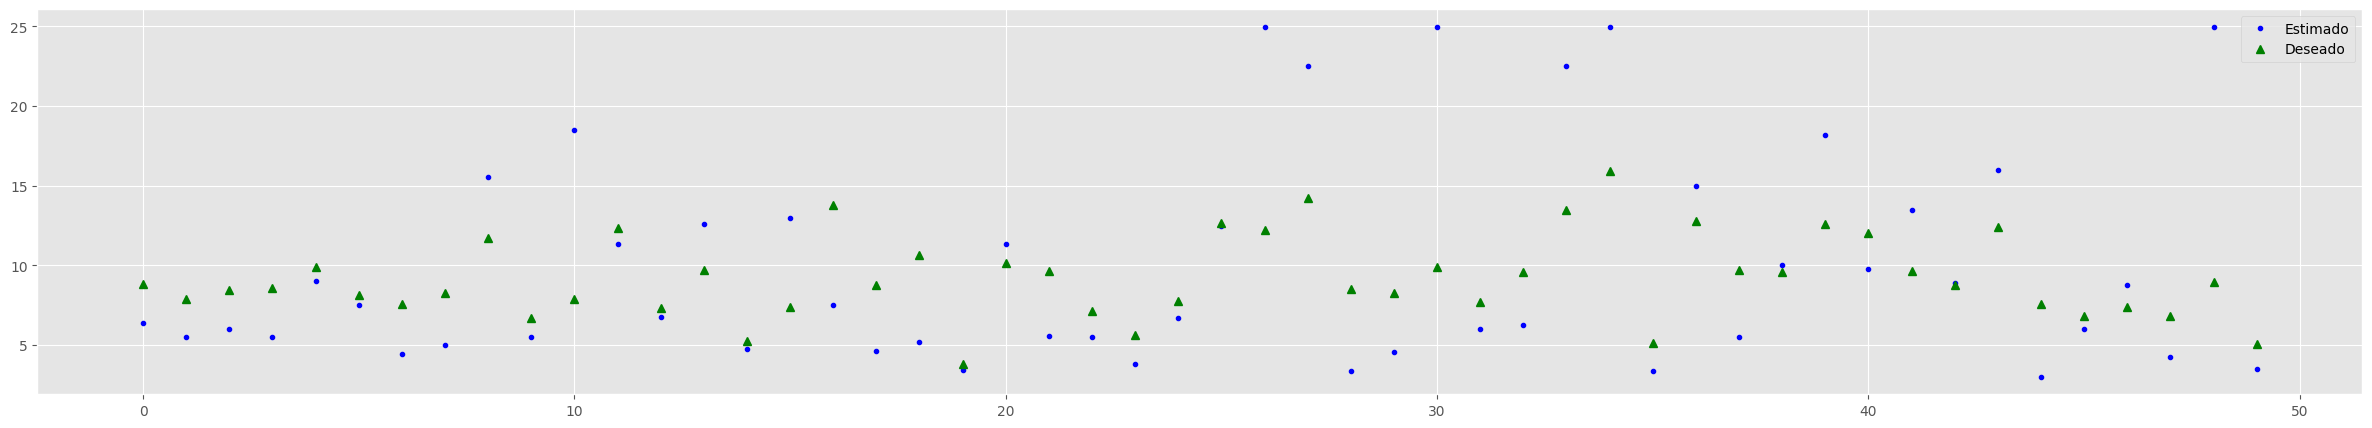

In [37]:
print(f"RMSE de regresión lineal: {rmse(y_test, pipe_regr.predict(X=X_test)):.3f} $/hora")

pintaResultados(pipe_regr,50)

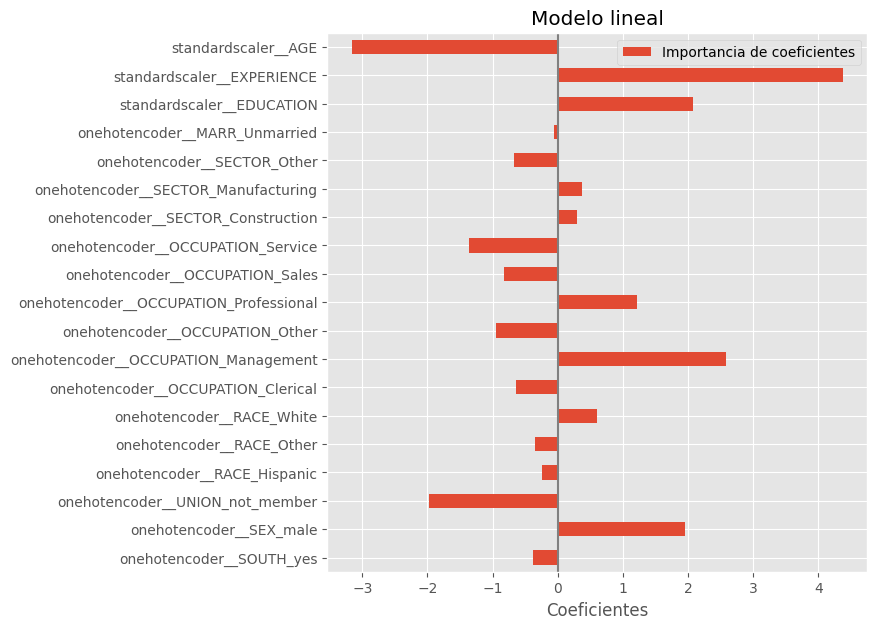

In [38]:
feature_names = pipe_regr[:-1].get_feature_names_out()

coefs = pd.DataFrame(
    pipe_regr['regresor'].coef_,
    columns=["Importancia de coeficientes"],
    index=feature_names,
)
coefs.plot.barh(figsize=(9, 7))
plt.title("Modelo lineal")
plt.xlabel("Coeficientes")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

## Ridge


In [39]:
# Creación y entrenamiento del modelo (con búsqueda por CV del valor óptimo alpha)
# ==============================================================================
# Por defecto RidgeCV utiliza el mean squared error


pipe_regrRidge = Pipeline([
        ('preproceso', preprocessor),
        ('regresor', RidgeCV(
            alphas          = np.logspace(-3, 8, 200),      # 10e-3 a 10e8 mejores alphas
            fit_intercept   = True,
            store_cv_values = True
         ))
])

np.random.seed(42)
pipe_regrRidge.fit(X_train, y_train)


Pipeline(steps=[('preproceso',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  Index(['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR'], dtype='object')),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  Index(['EDUCATION', 'EXPERIENCE', 'AGE'], dtype='object'))])),
                ('regresor',
                 RidgeCV(alphas=array([1.00000000e-03, 1.13573336e-0...
       5.35356668e+06, 6.08022426e+06, 6.90551352e+06, 7.84282206e+06,
       8.90735464e+06, 1.01163798e+07, 1.14895100e+07, 1.30490198e+07,
       1.48202071e+07, 1.68318035e+07, 1.91164408e+07, 2.17111795e+07,
       2.46581108e+07, 2.80050389e+07, 3.18062569e+07, 3.61234270e+07,
       4.10265811e+07, 4.65952567e+07, 5.29197874e+07, 6.01027678e+07,
       6.82607183e+07, 7.75259749e+07, 8.80488358e+07, 1.00000000e+08]),
                         store_cv_values=True))])

RMSE de regresión lineal RIDGE: 4.339 $/hora
Mejor aplpha: 18.04186409392072


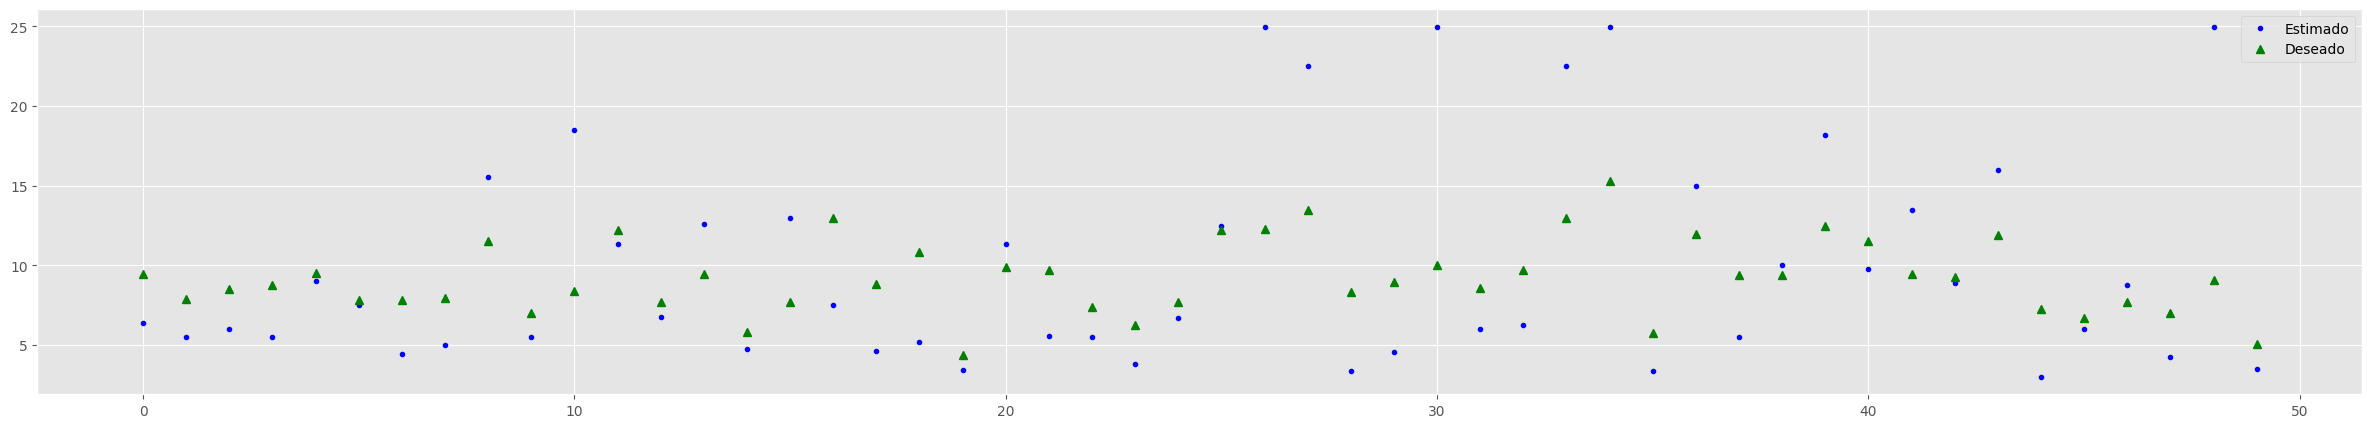

In [40]:
print(f"RMSE de regresión lineal RIDGE: {rmse(y_test, pipe_regrRidge.predict(X=X_test)):.3f} $/hora")
print(f"Mejor aplpha: {pipe_regrRidge['regresor'].alpha_}")

pintaResultados(pipe_regrRidge,50)

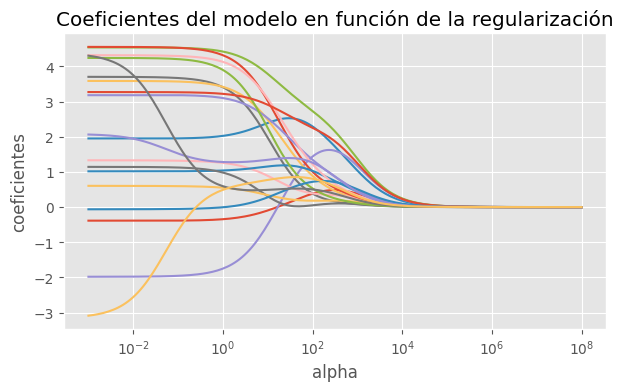

In [41]:
# Evolución de los coeficientes en función de alpha
# ==============================================================================
alphas = pipe_regrRidge['regresor'].alphas

coefs = []

for alpha in alphas:
    modelo_temp = Pipeline([
        ('preproceso', preprocessor),
        ('regresor', Ridge(alpha=alpha, fit_intercept=False))
    ])
    modelo_temp.fit(X_train, y_train)
    coefs.append(modelo_temp['regresor'].coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización');
plt.axis('tight')
plt.show()

Como vemos, a medida que aumenta el valor de alpha, la regularización es mayor y el valor de los coeficientes se reduce

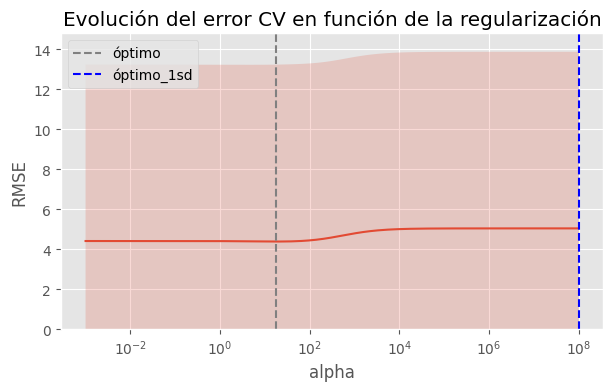

In [42]:
# Evolución del error en función de alpha
# ==============================================================================
# modelo.cv_values almacena el mse de cv para cada valor de alpha. Tiene
# dimensiones (n_samples, n_targets, n_alphas)
mse_cv = pipe_regrRidge['regresor'].cv_values_.reshape((-1, 200)).mean(axis=0)
mse_sd = pipe_regrRidge['regresor'].cv_values_.reshape((-1, 200)).std(axis=0)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = pipe_regrRidge['regresor'].alphas[np.argmin(rmse_cv)]
optimo_1sd   = pipe_regrRidge['regresor'].alphas[rmse_cv == min_rsme_1sd]


# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(pipe_regrRidge['regresor'].alphas, rmse_cv)
ax.fill_between(
    pipe_regrRidge['regresor'].alphas,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)


ax.axvline(
    x         = optimo,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

ax.axvline(
    x         = optimo_1sd,
    c         = "blue",
    linestyle = '--',
    label     = 'óptimo_1sd'
)
ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend();

In [43]:
# Mejor valor alpha encontrado
# ==============================================================================
print(f"Mejor valor de alpha encontrado: {pipe_regrRidge['regresor'].alpha_}")

Mejor valor de alpha encontrado: 18.04186409392072


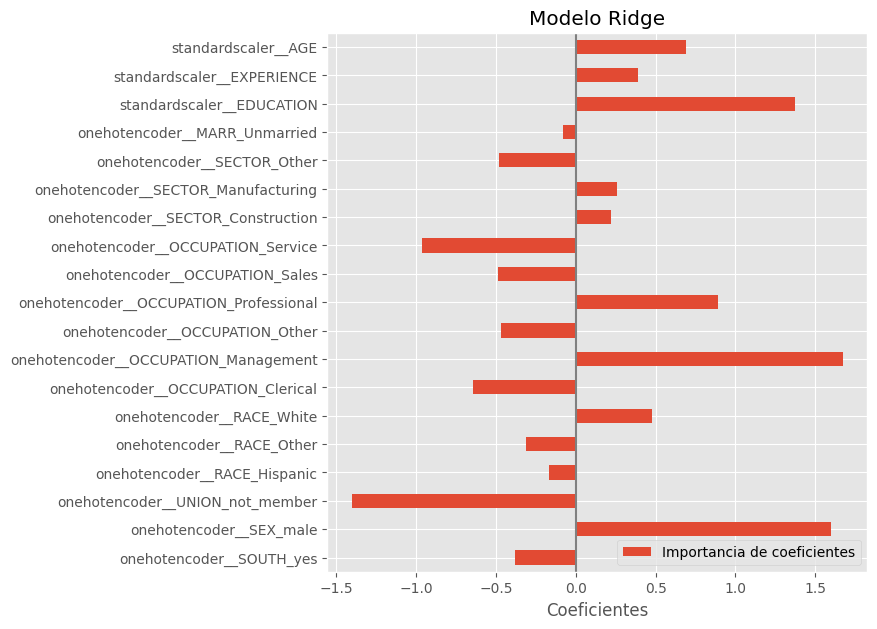

In [44]:
# Coeficientes del modelo
# ==============================================================================
coefs = pd.DataFrame(
    pipe_regrRidge['regresor'].coef_,
    columns=["Importancia de coeficientes"],
    index=feature_names,
)
coefs.plot.barh(figsize=(9, 7))
plt.title("Modelo Ridge")
plt.xlabel("Coeficientes")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

En comparación al modelo por mínimos cuadrados ordinarios, con ridge, el orden de magnitud de los coeficientes es menor.

## Lasso

In [45]:
# Creación y entrenamiento del modelo (con búsqueda por CV del valor óptimo alpha)
# ==============================================================================
# Por defecto LassoCV utiliza el mean squared error
pipe_regrLasso = Pipeline([
        ('preproceso', preprocessor),
        ('regresor', LassoCV(
            alphas          = np.logspace(-9, 3, 200),
            cv              = 3
         ))
])

np.random.seed(42)
pipe_regrLasso.fit(X = X_train, y = y_train)


Pipeline(steps=[('preproceso',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  Index(['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR'], dtype='object')),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  Index(['EDUCATION', 'EXPERIENCE', 'AGE'], dtype='object'))])),
                ('regresor',
                 LassoCV(alphas=array([1.00000000e-09, 1.14895100e-0...
       4.10265811e+01, 4.71375313e+01, 5.41587138e+01, 6.22257084e+01,
       7.14942899e+01, 8.21434358e+01, 9.43787828e+01, 1.08436597e+02,
       1.24588336e+02, 1.43145894e+02, 1.64467618e+02, 1.88965234e+02,
       2.17111795e+02, 2.49450814e+02, 2.86606762e+02, 3.29297126e+02,
       3.78346262e+02, 4.34701316e+02, 4.99450512e+02, 5.73844165e+02,
       6.59318827e+02, 7.57525026e+02, 8.70359136e+02, 1.00000000e+03]),
                         cv=3))])

RMSE de regresión lineal Lasso: 4.322 $/hora
Mejor aplpha: 0.034489622604057524


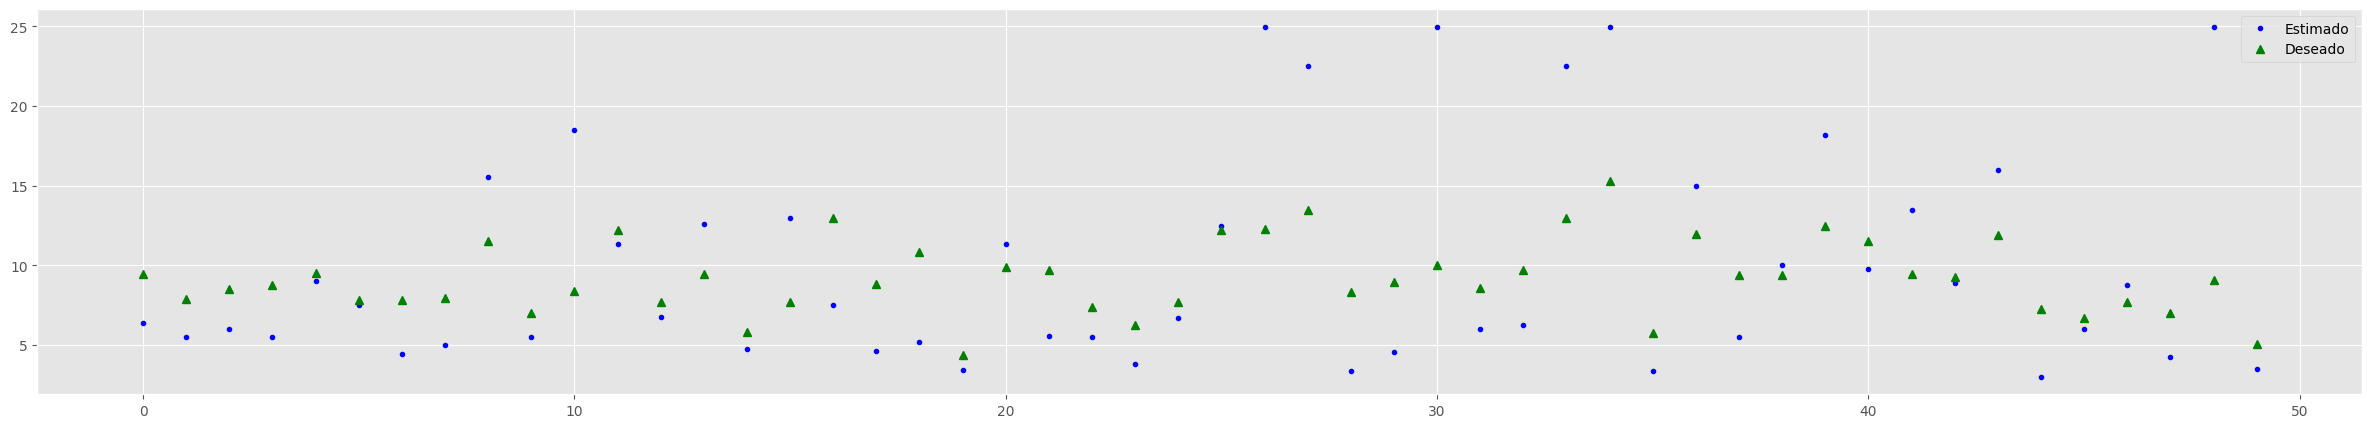

In [46]:
print(f"RMSE de regresión lineal Lasso: {rmse(y_test, pipe_regrLasso.predict(X=X_test)):.3f} $/hora")
print(f"Mejor aplpha: {pipe_regrLasso['regresor'].alpha_}")

pintaResultados(pipe_regrRidge,50)

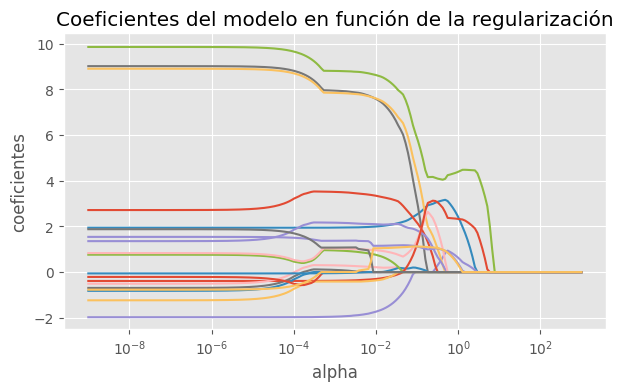

In [47]:
# Evolución de los coeficientes en función de alpha
# ==============================================================================
alphas = pipe_regrLasso['regresor'].alphas_
coefs = []

for alpha in alphas:
    modelo_temp = Pipeline([
        ('preproceso', preprocessor),
        ('regresor', Lasso(alpha=alpha, fit_intercept=False))
    ])
    modelo_temp.fit(X_train, y_train)
    coefs.append(modelo_temp['regresor'].coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_ylim([-2.5,None])
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización');

Puede ver se como, a medida que aumenta el valor de alpha, la regularización es mayor y más predictores quedan excluidos (su coeficiente es 0).

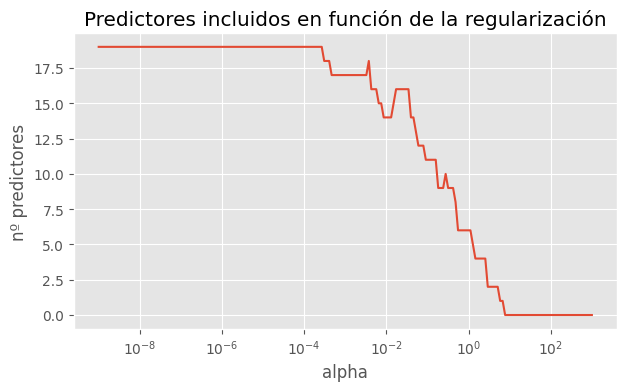

In [48]:
# Número de predictores incluidos (coeficiente !=0) en función de alpha
# ==============================================================================
alphas = pipe_regrLasso['regresor'].alphas_
n_predictores = []

for alpha in alphas:
    modelo_temp = Pipeline([
        ('preproceso', preprocessor),
        ('regresor', Lasso(alpha=alpha, fit_intercept=False))
    ])
    modelo_temp.fit(X_train, y_train)
    coef_no_cero = np.sum(modelo_temp['regresor'].coef_.flatten() != 0)
    n_predictores.append(coef_no_cero)


fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, n_predictores)
ax.set_xscale('log')
ax.set_ylim([-1,None])
ax.set_xlabel('alpha')
ax.set_ylabel('nº predictores')
ax.set_title('Predictores incluidos en función de la regularización');

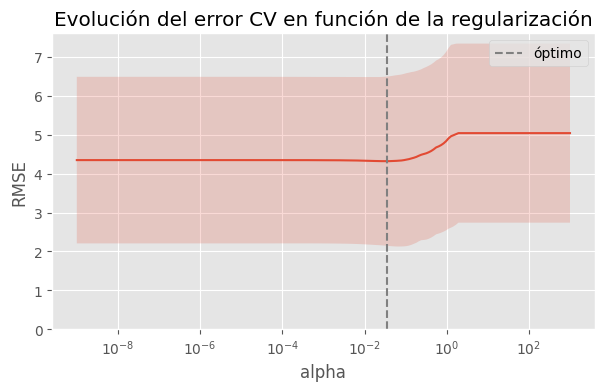

In [49]:
# Evolución del error en función de alpha
# ==============================================================================
# regrLasso.mse_path_ almacena el mse de cv para cada valor de alpha. Tiene
# dimensiones (n_alphas, n_folds)
mse_cv = pipe_regrLasso['regresor'].mse_path_.mean(axis=1)
mse_sd = pipe_regrLasso['regresor'].mse_path_.std(axis=1)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = pipe_regrLasso['regresor'].alphas_[np.argmin(rmse_cv)]
optimo_1sd   = pipe_regrLasso['regresor'].alphas_[rmse_cv == min_rsme_1sd]

# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(pipe_regrLasso['regresor'].alphas_, rmse_cv)
ax.fill_between(
    pipe_regrLasso['regresor'].alphas_,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

ax.axvline(
    x         = optimo,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

#ax.axvline(
#    x         = optimo_1sd,
#    c         = "blue",
#    linestyle = '--',
#    label     = 'óptimo_1sd'
#)

ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend();


In [50]:
# Mejor valor alpha encontrado
# ==============================================================================
print(f"Mejor valor de alpha encontrado: {pipe_regrLasso['regresor'].alpha_}")

Mejor valor de alpha encontrado: 0.034489622604057524


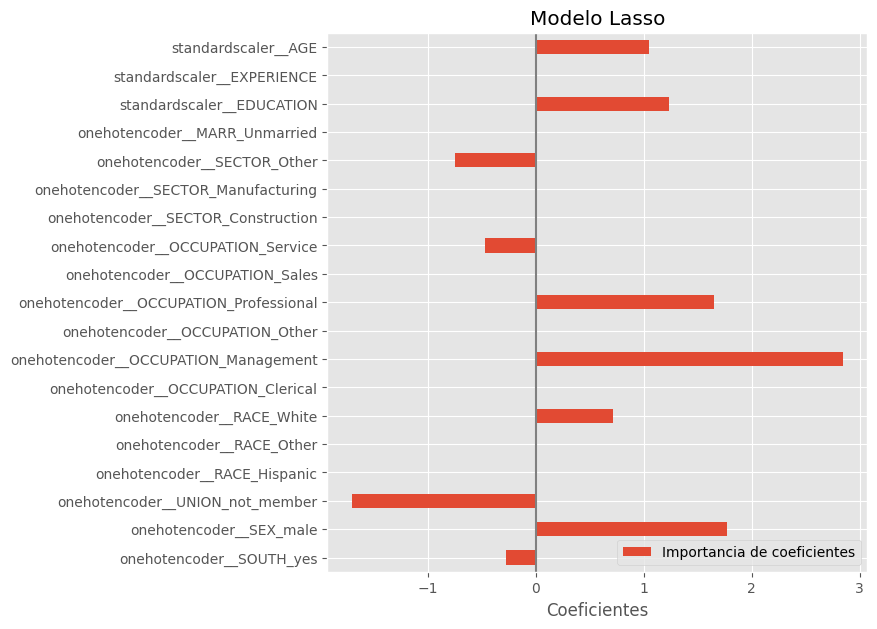

In [51]:
# Coeficientes del modelo
# ==============================================================================
coefs = pd.DataFrame(
    pipe_regrLasso['regresor'].coef_,
    columns=["Importancia de coeficientes"],
    index=feature_names,
)
coefs.plot.barh(figsize=(9, 7))
plt.title("Modelo Lasso")
plt.xlabel("Coeficientes")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

Comprobar como disminuye el número de predictores.

## Elastic Net

RMSE de regresión lineal - Elastic Net: 4.324 $/hora
Mejor aplpha: 0.03612342699709438
L1_ratio: 0.99


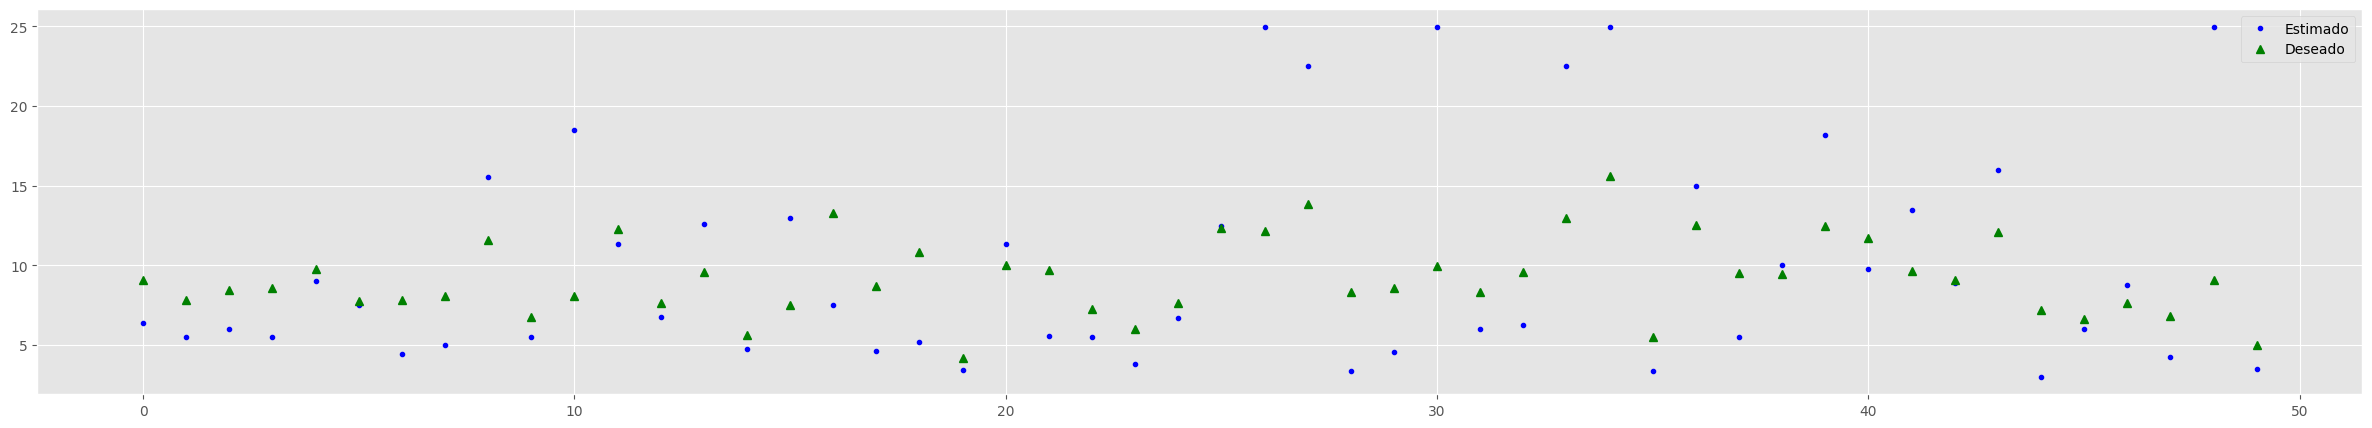

In [52]:
# ==============================================================================
# Por defecto ElasticNetCV utiliza el mean squared error
pipe_regrElastic = Pipeline([
        ('preproceso', preprocessor),
        ('regresor', ElasticNetCV(
            l1_ratio        = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
            alphas          = np.logspace(-10, 3, 200),
            cv              = 3)
        )
])

np.random.seed(42)
pipe_regrElastic.fit(X = X_train, y = y_train)
print(f"RMSE de regresión lineal - Elastic Net: {rmse(y_test, pipe_regrElastic.predict(X=X_test)):.3f} $/hora")
print(f"Mejor aplpha: {pipe_regrElastic['regresor'].alpha_}")
print(f"L1_ratio: {pipe_regrElastic['regresor'].l1_ratio_}")

pintaResultados(pipe_regrElastic,50)

In [53]:
# Evolución del error en función de alpha y l1_ratio
# ==============================================================================
# regrElastic.mse_path_ almacena el mse de cv para cada valor de alpha y l1_ratio.
# Tiene dimensiones (n_l1_ratio, n_alpha, n_folds)

# Error medio de las 10 particiones por cada valor de alpha y l1_ratio
mean_error_cv = pipe_regrElastic['regresor'].mse_path_.mean(axis =2)

# El resultado es un array de dimensiones (n_l1_ratio, n_alpha)
# Se convierte en un dataframe
df_resultados_cv = pd.DataFrame(
                        data   = mean_error_cv.flatten(),
                        index  = pd.MultiIndex.from_product(
                                    iterables = [pipe_regrElastic['regresor'].l1_ratio, pipe_regrElastic['regresor'].alphas_],
                                    names     = ['l1_ratio', 'modelo.alphas_']
                                 ),
                        columns = ["mse_cv"]
                    )

df_resultados_cv['rmse_cv'] = np.sqrt(df_resultados_cv['mse_cv'])
df_resultados_cv = df_resultados_cv.reset_index().sort_values('mse_cv', ascending = True)
df_resultados_cv

,l1_ratio,modelo.alphas_,mse_cv,rmse_cv
1268,0.99,0.036123,18.668128,4.320663
1269,0.99,0.031079,18.668239,4.320676
1069,0.95,0.031079,18.670747,4.320966
1068,0.95,0.036123,18.670911,4.320985
1270,0.99,0.026738,18.672884,4.321213
...,...,...,...,...
618,0.70,66.699197,25.424358,5.042257
619,0.70,57.384416,25.424358,5.042257
620,0.70,49.370479,25.424358,5.042257
622,0.70,36.543831,25.424358,5.042257


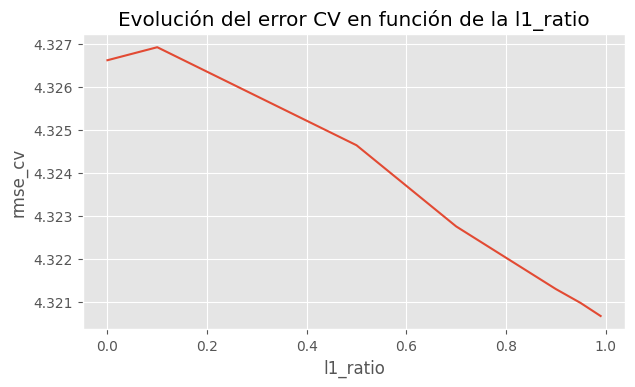

In [54]:
# Mejor valor encontrado para cada l1_ratio
fig, ax = plt.subplots(figsize=(7, 3.84))
df_resultados_cv.groupby('l1_ratio')['rmse_cv'].min().plot(ax = ax)
ax.set_title('Evolución del error CV en función de la l1_ratio')
ax.set_xlabel('l1_ratio')
ax.set_ylabel('rmse_cv');

In [55]:
# Mejor valor alpha y l1_ratio_ encontrado
# ==============================================================================
print(f"Mejor valor de alpha encontrado: {pipe_regrElastic['regresor'].alpha_}")
print(f"Mejor valor de l1_ratio encontrado: {pipe_regrElastic['regresor'].l1_ratio_}")

Mejor valor de alpha encontrado: 0.03612342699709438
Mejor valor de l1_ratio encontrado: 0.99


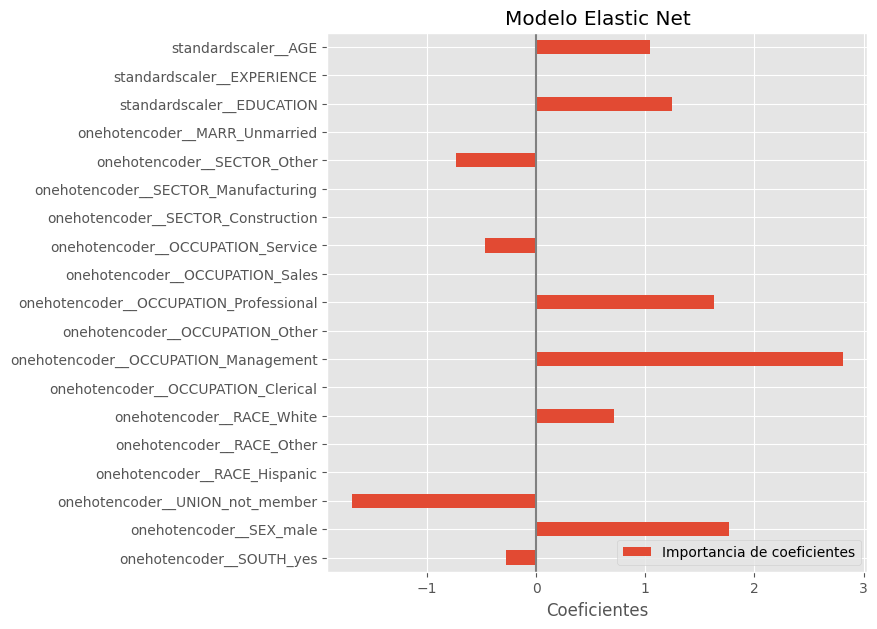

In [56]:
# Coeficientes del modelo
# ==============================================================================
coefs = pd.DataFrame(
    pipe_regrElastic['regresor'].coef_,
    columns=["Importancia de coeficientes"],
    index=feature_names,
)
coefs.plot.barh(figsize=(9, 7))
plt.title("Modelo Elastic Net")
plt.xlabel("Coeficientes")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

## Comparamos

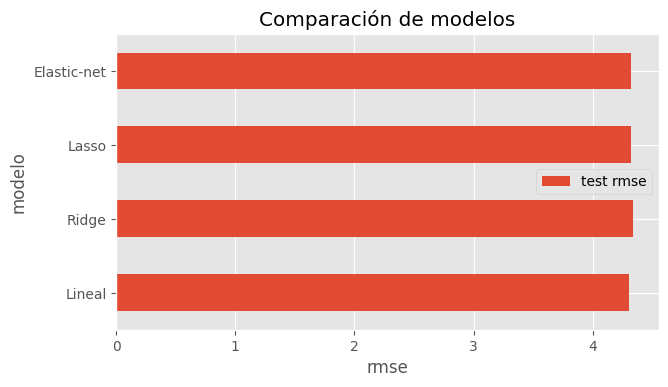

In [57]:
rmse_lineal = rmse(y_test, pipe_regr.predict(X=X_test))
rmse_ridge = rmse(y_test, pipe_regrRidge.predict(X=X_test))
rmse_lasso = rmse(y_test, pipe_regrLasso.predict(X=X_test))
rmse_elastic = rmse(y_test, pipe_regrElastic.predict(X=X_test))
df_comparacion = pd.DataFrame({
                    'modelo': ['Lineal', 'Ridge', 'Lasso', 'Elastic-net'],
                    'test rmse': [rmse_lineal, rmse_ridge, rmse_lasso, rmse_elastic]
                 })

fig, ax = plt.subplots(figsize=(7, 3.84))
df_comparacion.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_xlabel('rmse')
ax.set_ylabel('modelo')
ax.set_title('Comparación de modelos');

En este problema no hay mucha diferencia entre el modelo lineal y los modelos regularizados en cuanto al rmse. Sin embargo, como hemos visto, los valores de los coeficientes son menores.

# Regresión polinómica
Pasemos ahora a intentar una regresión polinómica. Haremos una búsqueda de los mejores hiperparámetros:
- 'grades': Grado del polinomio [2,3,4,5]

In [58]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score

degrees = [1, 2, 3, 4] # Change degree "hyperparameter" here
best_score = 0.0
best_degree = 0

for degree in degrees:
    poly_features = Pipeline([
        ('preproceso', preprocessor),
        ('regresor', PolynomialFeatures(degree = degree, include_bias=False))
    ])
    X_train_poly = poly_features.fit_transform(X_train)
    polynomial_regressor = LinearRegression()
    polynomial_regressor.fit(X_train_poly, y_train)
    scores = cross_val_score(polynomial_regressor, X_train_poly, y_train, cv=3) # Change k-fold cv value here
    print(f"Procesado {degree} con mejor valor R2: {max(scores)} ")
    if max(scores) > best_score:
      best_score = max(scores)
      best_degree = degree


Procesado 1 con mejor valor R2: 0.2898531960136377 
Procesado 2 con mejor valor R2: -2.9102000584683935e+22 
Procesado 3 con mejor valor R2: -438.1158934124675 
Procesado 4 con mejor valor R2: -150.9776787141168 


In [59]:
print(f"Mejor valor (R2): {best_score}")
print(f"Mejor valor de grado encontrado: {best_degree}")

Mejor valor (R2): 0.2898531960136377
Mejor valor de grado encontrado: 1


Creamos el modelo polinomial con los mejores parámetros:

In [60]:
poly_features = Pipeline([
   ('preproceso', preprocessor),
   ('regresor', PolynomialFeatures(degree = best_degree))
])
X_train_poly = poly_features.fit_transform(X_train)
best_polynomial_regressor = LinearRegression()
best_polynomial_regressor.fit(X_train_poly, y_train)
X_test_poly = poly_features.fit_transform(X_test)
print(f"RMSE de regresión polinómica: {rmse(y_test, best_polynomial_regressor.predict(X=X_test_poly))}")


RMSE de regresión polinómica: 4.292234993134445


In [61]:
print(best_polynomial_regressor.coef_)

[ 0.         -0.38641147  1.95141597 -1.98136227 -0.23985661 -0.3567065
  0.5965631  -0.64073325  2.58308866 -0.95545513  1.20919059 -0.82860722
 -1.36748366  0.2973161   0.37541435 -0.67273045 -0.06351903  2.0786343
  4.37657171 -3.15777176]
